In [18]:
# Import all necessary libraries and create spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,upper,udf,element_at,explode,regexp_replace,size
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DateType

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

import os

spark = SparkSession \
    .builder \
    .appName("FHIR Analytics with Python") \
    .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions") \
    .getOrCreate()
keyspace = "myCatalog.hfs_data"


In [19]:
# create a reference to our Cassandra catalog
spark.conf.set("spark.sql.catalog.myCatalog", "com.datastax.spark.connector.datasource.CassandraCatalog")

# Increase memory for better performance
spark.conf.set("spark.cassandra.input.split.sizeInMB", "67108864")


In [20]:
# define UDFs to pull some data out of our structs
def getMaritalStatus(ms):
    if (ms == None):
        return None
    return ms.text_
gms = udf(getMaritalStatus, StringType())
def getBirthDate(bd):
    return bd[0]
gbd = udf(getBirthDate, DateType())

# a reusable function to get a specific LOINC code and average all for by Patient ID
def getAvgForLoinc(loinc_code, agg_column, df):
    return df.filter(col("LoincCode").like(loinc_code)) \
                         .withColumnRenamed("ValueQuantity", agg_column) \
                         .select(col("Subject"), col(agg_column)) \
                         .groupBy("Subject").agg(F.round(F.avg(col(agg_column)), 3).alias(agg_column))

In [21]:
# Read in the tables we care about
rawPatient = spark.read.table(keyspace + ".patient")
rawReference = spark.read.table(keyspace + ".reference")
rawObservation = spark.read.table(keyspace + ".observation")
rawEncounter = spark.read.table(keyspace + ".encounter")

# An alternative way to read tables, left for reference
#rawReference = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "reference","keyspace": "hfs_data"}).load()
#rawObservation = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "observation","keyspace": "hfs_data"}).load()


In [22]:
# select id, maritalstatus._text, birthdate and gender from patient
# calculate patient age

patientDataFrame = rawPatient.select(col("id").alias("PatientId"), gms(col("maritalstatus")).alias("Marital Status"), col("birthdate")["0"].alias("birthdate"), upper(col("gender")).alias("Gender")).withColumn("Age", F.round(F.datediff(F.current_date(), F.to_date(col("birthdate"))) / 365, 1))

In [23]:
patientDataFrame.cache()
patientDataFrame.count()

4509

In [24]:
# select only Patient references and manipulate the column values so they are ready for joining with other tables

referenceDataFrame = rawReference.where(rawReference.reference.like("Patient%")).select(regexp_replace(rawReference.id, "#hidden", "").alias("id"), regexp_replace(rawReference.reference, "Patient/", "").alias("reference"))

In [25]:
referenceDataFrame.cache()
referenceDataFrame.count()

1723782

In [26]:
# rename some observation columns AND join with reference table to resolve Patient ID references properly

observationDataFrame = rawObservation.select(col("id").alias("ObservationId"), col("code"), col("component"), col("valuequantity"), col("subject").alias("PatientReferenceId"))
observationDataFrame = observationDataFrame.join(referenceDataFrame, referenceDataFrame.id == observationDataFrame.PatientReferenceId) \
                  .withColumn("id", col("id").cast(StringType())).withColumn("reference", col("reference").cast(StringType())) \
                  .withColumnRenamed('reference', "PatientId") \
                  .drop(col("id")) \
                  .drop(col("PatientReferenceId"))




In [27]:
# Filter and select LOINC information from observation dataframe

observationDataFrame_loinc = observationDataFrame \
    .select(col("PatientId").alias("Subject"), \
            col("ObservationId"), \
            col("code").coding[0].code.alias("LoincCode"), \
            col("valuequantity").value.alias("ValueQuantity"))

loinc_code_list = ["8480-6", "8462-4","29463-7","8302-2","33914-3","2571-8","2085-9","18262-6","2093-3","39156-5","55284-4", "195967001", "233678006"]


observationDataFrame_loinc = observationDataFrame_loinc \
    .filter(col("LoincCode").isin(loinc_code_list))\
    .na.drop()

In [28]:
observationDataFrame_loinc.cache()

DataFrame[Subject: string, ObservationId: string, LoincCode: string, ValueQuantity: decimal(38,18)]

In [29]:
# Select only Body Weight observations from pre-filtered observation data frame

body_weight_df = observationDataFrame_loinc \
    .filter(col("LoincCode").like("%29463-7%")) \
    .withColumnRenamed("ValueQuantity", "Body Weight") \
    .select(col("Subject"), col("Body Weight")) \
    .na.drop() \
    .dropDuplicates()

In [30]:
# Calculate Systolic, Dystolic and total BP, then avg per patient

blood_pressure_df = observationDataFrame.select(col("PatientId").alias("Subject"),
                          "ObservationId",
                          col("component")[0].code.coding[0].code.alias("DBPCode"), \
                          col("component")[0].valuequantity.value.alias("Diastolic Blood Pressure"), \
                          col("component")[1].code.coding[0].code.alias("SBPCode"), \
                          col("component")[1].valuequantity.value.alias("Systolic Blood Pressure")).na.drop()



blood_pressure_df = blood_pressure_df.withColumn("Blood Pressure", \
      F.round(col("Diastolic Blood Pressure")+(col("Systolic Blood Pressure") - col("Diastolic Blood Pressure"))/3))

blood_pressure_avg_df = blood_pressure_df.groupBy(col("Subject")).agg(F.round(F.avg("Diastolic Blood Pressure"), 3).alias("Diastolic BP"), \
                                           F.round(F.avg("Systolic Blood Pressure"), 3).alias("Systolic BP"), \
                                           F.round(F.avg("Blood Pressure"), 3).alias("BP") \
                                          )


In [31]:
# Select all encounters that show as Asthma diagnoses

encounterDataFrame = rawEncounter.filter(F.size(col("reasoncode")) > 0).select(col("subject"), col("reasoncode")[0].coding[0]["code"].alias("Asthma")) \
                                 .withColumn("Asthma", F.when(col("Asthma").isin(["195967001","233678006"]), F.lit(1)).otherwise(F.lit(0)))

encounterDataFrame = encounterDataFrame.join(referenceDataFrame, encounterDataFrame.subject == referenceDataFrame.id) \
                                               .drop("subject", "id") \
                                               .withColumnRenamed("reference", "subject")

encounterDataFrame_asthma = encounterDataFrame.groupBy("subject").agg(F.max(col("Asthma")).alias("Asthma"))

In [32]:
# Calculate avg body weight per patient and join with patient data frame

patient_calc_df = body_weight_df.groupBy("Subject").agg(F.round(F.avg("Body Weight"), 3).alias("Body Weight")) \
                                .join(patientDataFrame, body_weight_df.Subject == patientDataFrame.PatientId) \
                                .drop("Subject")

# Add literal demo info to patients
patient_calc_df = patient_calc_df.dropDuplicates() \
                                 .withColumn("Disease", F.array(F.lit("0"))) \
                                 .withColumn("PostalCode", F.array(F.lit("0")))

# Join BP info by patient
patient_calc_df = patient_calc_df.join(blood_pressure_avg_df, \
                                             blood_pressure_avg_df.Subject == patient_calc_df.PatientId, "left") \
                                       .drop("Subject")
     

# Join asthma info by patient
patient_calc_df = patient_calc_df.join(encounterDataFrame_asthma, encounterDataFrame_asthma.subject == patient_calc_df.PatientId, "left") \
                   .dropDuplicates() \
                   .drop(col("subject"))

# Calculate and join avg triglycerides by patient
triglycerides_df = getAvgForLoinc("%2571-8%", "Triglycerides", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(triglycerides_df, patient_calc_df.PatientId == triglycerides_df.Subject, "left") \
                                 .drop(col("Subject"))


# Calculate and join average EGFR by patient
egfrLoincCode = ["88294-4", "33914-3"]
agg_column = "Estimated Glomerular Filtration Rate"

egfr_df = observationDataFrame_loinc.select(col("Subject"), col("LoincCode"), col("ValueQuantity")) \
                                 .filter(col("LoincCode").isin(egfrLoincCode)) \
                                 .withColumn(agg_column, col("ValueQuantity")) \
                                 .groupBy("Subject").agg(F.round(F.avg(col(agg_column))).alias(agg_column))

patient_calc_df = patient_calc_df.join(egfr_df, patient_calc_df.PatientId == egfr_df.Subject, "left") \
                                 .drop(col("Subject"))

# Calculate and join avg LDL by patient
ldl_df = getAvgForLoinc("%18262-6%", "Low Density Lipoprotein", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(ldl_df, patient_calc_df.PatientId == ldl_df.Subject, "left") \
                   .dropDuplicates().drop(col("Subject"))


# Calculate and join average HDL by patient
hdl_df = getAvgForLoinc("%2085-9%", "High Density Lipoprotein Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(hdl_df, patient_calc_df.PatientId == hdl_df.Subject, "left") \
                   .drop(col("Subject"))

# Calculate and join average height by patient
height_df = getAvgForLoinc("%8302-2%", "Body Height", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(height_df, patient_calc_df.PatientId == height_df.Subject, "left") \
                   .drop(col("Subject"))

#Calculate and join average BMI by patient
bmi_df = getAvgForLoinc("%39156-5%", "BMI", observationDataFrame_loinc)
    
patient_calc_df = patient_calc_df.join(bmi_df, patient_calc_df.PatientId == bmi_df.Subject, "left") \
                   .drop(col("Subject"))

#Calculate and join average cholesterol by patient
cholesterol_df = getAvgForLoinc("%2093-3%", "Total Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(cholesterol_df, patient_calc_df.PatientId == cholesterol_df.Subject, "left") \
                   .drop(col("Subject"))

In [33]:
# Drop some non predictors and any rows with nulls
asthma_dataset = patient_calc_df.drop("PatientId", "Disease", "PostalCode", "birthdate", "Diagnosed Date").na.drop()

In [34]:
asthma_dataset.cache()
# check how many patients with asthma we have after doing the cleaning of data, a good size sample is important for a good model
asthma_dataset.filter(col("Asthma") ==1).count()

177

In [35]:
asthma_dataset.cache()

DataFrame[Body Weight: decimal(38,3), Marital Status: string, Gender: string, Age: double, Diastolic BP: decimal(38,3), Systolic BP: decimal(38,3), BP: decimal(38,3), Asthma: int, Triglycerides: decimal(38,3), Estimated Glomerular Filtration Rate: decimal(38,0), Low Density Lipoprotein: decimal(38,3), High Density Lipoprotein Cholesterol: decimal(38,3), Body Height: decimal(38,3), BMI: decimal(38,3), Total Cholesterol: decimal(38,3)]

In [36]:
asthma_dataset.show()

+-----------+--------------+------+-----+------------+-----------+-------+------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|Body Weight|Marital Status|Gender|  Age|Diastolic BP|Systolic BP|     BP|Asthma|Triglycerides|Estimated Glomerular Filtration Rate|Low Density Lipoprotein|High Density Lipoprotein Cholesterol|Body Height|   BMI|Total Cholesterol|
+-----------+--------------+------+-----+------------+-----------+-------+------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|     87.436|             S|  MALE| 98.3|      80.517|    119.310| 93.483|     1|      153.729|                                  34|                106.059|                              61.046|    175.200|28.816|          179.925|
|     79.900|             M|  MALE| 55.9|      78.545|    123.182| 93.318|  

In [37]:
trainDF, testDF = asthma_dataset.randomSplit([.8, .2], seed = 42)
print(f"""There are {trainDF.count()} rows in the training set and {testDF.count()} in the test set""")

There are 233 rows in the training set and 40 in the test set


In [38]:
# prepare the data for regressions

categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols = categoricalCols, outputCols = indexOutputCols, handleInvalid = "skip")
oheEncoder = OneHotEncoder(inputCols = indexOutputCols, outputCols = oheOutputCols)

numericCols = [field for (field, dataType) in trainDF.dtypes
                if dataType != "string" and field != "Asthma"]

assemblerInputs = oheOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

In [39]:
from pyspark.ml.classification import LogisticRegression

# the 1 for elasticNetParam makes this a LASSO regression
lr = LogisticRegression(labelCol = "Asthma", featuresCol = "features", maxIter=10, elasticNetParam = 1)

# construct an ML pipeline - this is a reproducible set of steps for the data manipulation
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

# Fit the model
lrModel = pipeline.fit(trainDF)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.stages[-1].coefficients))
print("Intercept: " + str(lrModel.stages[-1].intercept))

# Test the test set using the model
predDF = lrModel.transform(testDF)

#show all the positive Asthma cases in the test set and the predictions
predDF.select("features", "Asthma", "prediction").filter((col("Asthma") ==1)).show()

Coefficients: [0.5997257625718431,-0.11971540867225226,-0.8897179802938445,-0.007718132253374646,-0.0062416213712803755,0.010368001512818114,0.010903384341787751,0.011159211528305225,-0.02317032059116305,-0.030522913729591226,0.021676420690734968,0.001293184213651238,0.0056136656364702735,0.07151971129603955,-0.009702515411718965]
Intercept: 0.6649878979856585
0.7854077253218884
+--------------------+------+----------+
|            features|Asthma|prediction|
+--------------------+------+----------+
|[0.0,1.0,1.0,93.3...|     1|       1.0|
|[1.0,0.0,1.0,85.9...|     1|       1.0|
|[0.0,1.0,0.0,73.7...|     1|       1.0|
|[0.0,1.0,1.0,79.6...|     1|       1.0|
|[0.0,1.0,0.0,81.7...|     1|       1.0|
|[1.0,0.0,0.0,73.6...|     1|       1.0|
|[0.0,1.0,0.0,67.1...|     1|       1.0|
|[1.0,0.0,0.0,75.8...|     1|       1.0|
|[0.0,1.0,0.0,69.2...|     1|       1.0|
|[0.0,1.0,0.0,66.4...|     1|       1.0|
|[1.0,0.0,1.0,96.2...|     1|       0.0|
|[1.0,0.0,1.0,80.9...|     1|       1.0|
|[1

In [41]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Spark will automatically train 4 different models testing the regParam in the array each time and then select the best model
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.05, .3]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol = "Asthma"),
                          numFolds=2
                         )  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(trainDF)

In [42]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = cvModel.bestModel.stages[-1].summary

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
# F-Measure is a statistical analysis measurement that helps judge the quality of a model
# it uses the number of correct positive predictions / total number positive predictions 
#    and the number of correct positive predictions / total number of true values

fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
print(maxFMeasure)


bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print(bestThreshold)

+------+--------------------+
|   FPR|                 TPR|
+------+--------------------+
|   0.0|                 0.0|
|   0.0|0.006535947712418301|
|   0.0|0.013071895424836602|
|0.0125|0.013071895424836602|
|0.0125|  0.0196078431372549|
|0.0125|0.026143790849673203|
|0.0125|0.032679738562091505|
|0.0125|  0.0457516339869281|
|0.0125| 0.05228758169934641|
|0.0125|0.058823529411764705|
|0.0125| 0.06535947712418301|
|0.0125|  0.0718954248366013|
|0.0125|  0.0784313725490196|
|0.0125|  0.0915032679738562|
| 0.025|  0.0915032679738562|
| 0.025| 0.09803921568627451|
| 0.025| 0.10457516339869281|
| 0.025|  0.1111111111111111|
| 0.025| 0.11764705882352941|
| 0.025| 0.13071895424836602|
+------+--------------------+
only showing top 20 rows

areaUnderROC: 0.8086192810457518
Row(max(F-Measure)=0.8264984227129337)
0.5435905001218698


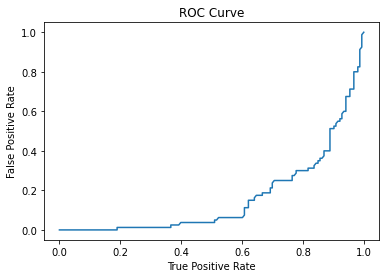

Training set areaUnderROC for untuned model: 0.8391339869281047


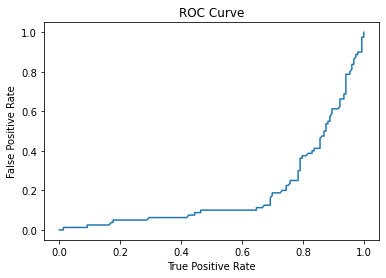

Training set areaUnderROC for BEST model: 0.8086192810457518


In [45]:
import matplotlib.pyplot as plt 

# Plot ROC curve, which lets you see false positive rate as a function of true positive rate, showing how you can tune your model

roc = lrModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['TPR'],roc['FPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for untuned model: ' + str(lrModel.stages[-1].summary.areaUnderROC))

roc = cvModel.bestModel.stages[-1].summary.roc.toPandas()
plt.plot(roc['TPR'],roc['FPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC for BEST model: ' + str(cvModel.bestModel.stages[-1].summary.areaUnderROC))